In [918]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats as spicystats
import sys

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, roc_curve

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from pandas.plotting import scatter_matrix
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest


from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import f1_score, log_loss

sys.path.insert(0, '../src')
sys.path.insert(0, '../data')


import chess

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [941]:
# Read in chess dataset and sample it. Drop columns containing immaterial data.
chess_games = pd.read_csv("../data/games.csv")
chess_games.drop(['rated', 'id', 'created_at', 'last_move_at', 'increment_code', 'white_id', 'black_id', 'opening_eco'], axis=1, inplace=True)
chess_games.sample(10)  

,turns,victory_status,winner,white_rating,black_rating,moves,opening_name,opening_ply
17415,99,resign,white,1738,1629,b3 e5 Bb2 e4 d3 Nf6 dxe4 Nxe4 Nd2 Nxd2 Qxd2 d6...,Nimzo-Larsen Attack: Modern Variation #2,3
6376,49,resign,white,1470,1625,e4 c6 Nf3 d5 e5 Bf5 d4 e6 Nc3 c5 Be3 cxd4 Nxd4...,Caro-Kann Defense: Advance Variation | Short ...,7
19221,29,resign,black,1389,1339,e4 e5 Nf3 Qf6 Nc3 Bc5 Bc4 c6 d3 d5 exd5 h6 Ne4...,King's Pawn Game: McConnell Defense,4
8865,52,mate,black,1850,1905,Nf3 Nf6 d4 e6 e3 b6 Nc3 Bb7 b3 Bb4 Bb2 Ne4 Bd3...,Yusupov-Rubinstein System,5
259,38,resign,black,1649,1547,e4 e6 d4 d5 e5 c5 c4 dxc4 Bxc4 cxd4 Nf3 Nc6 b3...,French Defense: Advance Variation #4,6
10344,33,mate,white,1620,1565,e4 e5 Nc3 Nc6 Nf3 d6 Bb5 Bd7 O-O Nh6 d3 Qc8 Be...,Three Knights Opening,5
9868,54,resign,white,1336,1217,Nf3 d5 d4 Nc6 h3 e6 c3 Nf6 Nbd2 Bd6 e3 O-O Bd3...,Queen's Pawn Game: Chigorin Variation,4
4364,48,mate,black,1086,1774,d4 d5 c4 c6 e3 Nf6 Nf3 Bg4 h3 Bh5 g4 Bg6 Bd3 B...,Slav Defense: Quiet Variation | Pin Defense,8
8882,92,resign,black,1006,1399,e4 e6 d4 d5 e5 Ne7 Nf3 Nf5 Bd3 Be7 O-O O-O g3 ...,French Defense: Advance Variation #3,5
6233,23,outoftime,white,1500,1099,d4 d5 Bf4 Bg4 e3 Bxd1 Kxd1 b5 Bxb5+ c6 Bd3 a5 ...,Queen's Pawn Game: Mason Attack,3


In [935]:
# Analyze breakdown of game outcomes, which are, mate, resign, draw, and out of time.
def chess_outcome_breakdown(chess_df):
    victory_status = chess_df['victory_status'].value_counts()
    return victory_status
chess_outcome_breakdown(chess_games)

resign       11147
mate          6325
outoftime     1680
draw           906
Name: victory_status, dtype: int64

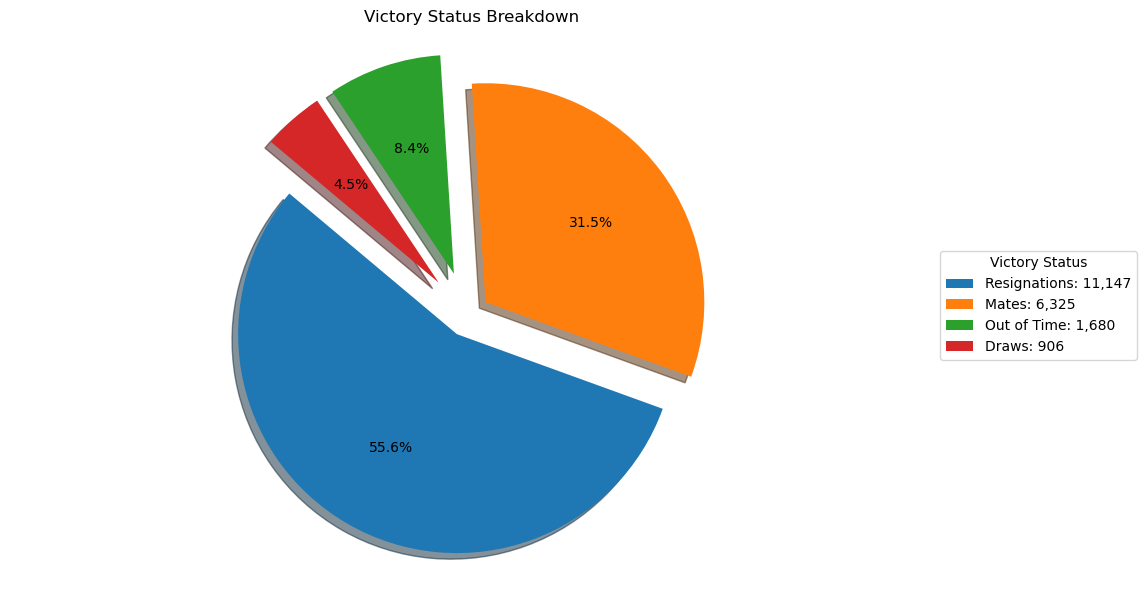

In [1040]:
# Grab and count the chess victory status, broken down by category. Make pie chart to depict the delineations.

def chess_victories(chess_df, path='../images/chess_outcomes_breakdown.png'):
     victory_status = chess_df['victory_status'].value_counts()

     fig, ax = plt.subplots(figsize = (10,6))

     sizes = victory_status.values
     labels = ['Resignations: 11,147', 'Mates: 6,325', 'Out of Time: 1,680', 'Draws: 906']
     explode = (0.1, 0.1, 0.2, 0.2)
     c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
     plt.pie(sizes, explode=explode, colors=c, 
        autopct='%1.1f%%', shadow=True, startangle=140)
     ax.legend( labels, title="Victory Status",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
     ax.set_title("Victory Status Breakdown")
     plt.tight_layout()
     plt.axis('equal')
     plt.savefig(path)
     return victory_status
victories_breakdown = chess_victories(chess_games)



('95.48309901286271', '4.516900987137302')

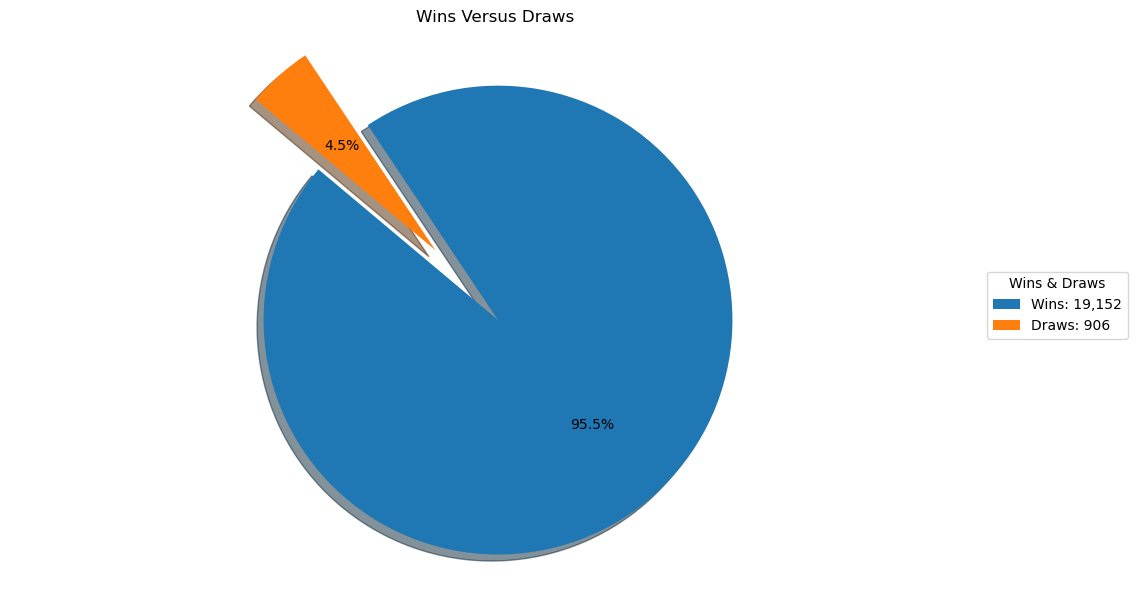

In [1041]:
# Look at games won, by mate, out of time, and resignation, and compare to draws. Make pie charts for both delineations. 

def wins_versus_draws(chess_df, path='../images/wins_versus_draws.png'):
    game_status = chess_games['victory_status'].value_counts('draw')
    game_status_percent = game_status * 100
    victories_percent = str(sum(game_status_percent.iloc[:3]))
    draws_percent = str(sum(game_status_percent.iloc[-1:]))
    game_wins = sum(game_status.iloc[:3])
    game_draws = sum(game_status.iloc[-1:])
    
    fig, ax = plt.subplots(figsize = (10,6))

    sizes = victories_percent, draws_percent
    labels = ['Wins: 19,152', 'Draws: 906']
    explode = (0.2, 0.2)
    c = ['#1f77b4', '#ff7f0e']
    plt.pie(sizes, explode=explode, colors=c, 
        autopct='%1.1f%%', shadow=True, startangle=140)
    ax.legend(labels, title="Wins & Draws",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
    ax.set_title("Wins Versus Draws")
    plt.tight_layout()
    plt.axis('equal')
    plt.savefig(path)
    return victories_percent, draws_percent
wins_versus_draws(chess_games)

In [797]:
# Null Hypothesis: The rating differential between black and white has no significant impact on which player wins the game.
# Alternate Hypothesis: The rating differential between black and white has a significant impact on which player wins the game.

C:\Users\muscl\AppData\Local\Temp\ipykernel_10528\4065744979.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  white_greater_100['winner'] = white_greater_100['winner'].apply(victory_status).astype(int)


,turns,victory_status,winner,white_rating,black_rating,moves,opening_name,opening_ply,Rating Differential White
0,13,outoftime,1,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,Slav Defense: Exchange Variation,5,309
5,5,draw,0,1250,1002,e4 c5 Nf3 Qa5 a3,Sicilian Defense: Mongoose Variation,4,248
9,119,mate,1,1381,1209,e4 d5 exd5 Qxd5 Nc3 Qe5+ Be2 Na6 d4 Qf5 Bxa6 b...,Scandinavian Defense: Mieses-Kotroc Variation,4,172
10,39,mate,1,1381,1272,e3 e6 d4 d6 Bd3 c6 Nf3 Be7 Nc3 Nf6 Bd2 Bd7 Qe2...,Van't Kruijs Opening,1,109
19,25,resign,1,1500,1094,d4 d5 h3 Nc6 Nf3 Nf6 Bg5 h6 Bxf6 exf6 e3 Bb4+ ...,Queen's Pawn Game,2,406
...,...,...,...,...,...,...,...,...,...
20042,53,resign,1,1759,1265,e4 d6 d4 Nf6 Nc3 Nbd7 f4 e5 Nf3 Be7 dxe5 dxe5 ...,Lion Defense: Anti-Philidor | Lion's Cave,8,494
20044,37,mate,1,1523,1256,e4 e6 d4 d5 e5 Nc6 Nf3 f6 Bb5 Bd7 O-O Nge7 exf...,French Defense: Advance Variation #3,5,267
20050,9,outoftime,1,1243,1142,c4 e5 d4 exd4 Qxd4 Nf6 Bg5 Be7 e4,English Opening: King's English Variation,2,101
20053,24,resign,1,1691,1220,d4 f5 e3 e6 Nf3 Nf6 Nc3 b6 Be2 Bb7 O-O Be7 Ne5...,Dutch Defense,2,471


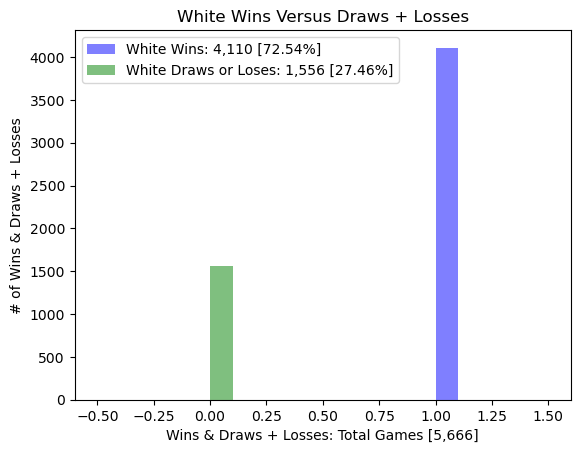

In [954]:
# Look at stronger white players, greater than 100 ELO, and map wins to 1 and draws or losses to 0.
# Perform t-test to analyze the p-value and ultimately the null & alternate hypotheses for white differentials.
# Histogram pot displaying white wins versus white draws when white is the superior opponent.

def chess_differentials_white(chess_df):
    chess_df = chess_df.copy()
    chess_df['Rating Differential White'] = (chess_df['white_rating'] - chess_df['black_rating']).astype(int)
    black_wins = chess_df[(chess_df['Rating Differential White'] > 100) & (chess_df['winner'] == 'black')].value_counts()
    white_greater_100 = chess_df[(chess_df['Rating Differential White'] > 100)]
    
    def victory_status(s):
        if s == 'black' or s == 'draw' :
            return 0

        else:
            return 1
    
    white_greater_100['winner'] = white_greater_100['winner'].apply(victory_status).astype(int)
    
    white_ttest = spicystats.ttest_ind(white_greater_100['Rating Differential White'], white_greater_100['winner'], equal_var = False)
    
    fig,ax = plt.subplots()

    white_victory = white_greater_100[white_greater_100['winner'] == 1]
    white_draw_or_loss = white_greater_100[white_greater_100['winner'] == 0]
    

    ax.hist(white_victory['winner'], color = 'b', alpha = 0.5, label = 'White Wins: 4,110 [72.54%]')
    ax.hist(white_draw_or_loss['winner'], color = 'g', alpha = 0.5, label = 'White Draws or Loses: 1,556 [27.46%]')
    ax.set_title('White Wins Versus Draws + Losses')
    ax.set_ylabel('# of Wins & Draws + Losses')
    ax.set_xlabel('Wins & Draws + Losses: Total Games [5,666]')

    ax.legend();
    
    white_win_percentage = (4110 /(4110+1556))*100
    white_draw_or_loss_percentage = (1556 /(4110+1556))*100
    return white_greater_100
    # , white_ttest, white_victory, white_draw_or_loss, white_win_percentage, white_draw_or_loss_percentage, black_wins

chess_outcomes_white = chess_differentials_white(chess_games)
chess_outcomes_white

# The p-value is less than 0.05, so we reject the null hypothesis and there is significant difference, or impact, 
# between the white rating differentials, with white being the superior opponent, and who wins the game.
# When only considering wins and draws plus losses of a higher-ranked white opponent, white wins 72.54% of the time and draws or loses 27.46% of the time over 5,666 games.

C:\Users\muscl\AppData\Local\Temp\ipykernel_10528\3519963764.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  black_greater_100['winner'] = black_greater_100['winner'].apply(victory_status).astype(int)


,turns,victory_status,winner,white_rating,black_rating,moves,opening_name,opening_ply,Rating Differential Black
7,9,resign,1,1413,2108,e4 Nc6 d4 e5 d5 Nce7 c3 Ng6 b4,Nimzowitsch Defense: Kennedy Variation | Link...,5,695
11,38,resign,1,1381,1867,e4 e6 d4 d5 e5 c5 c3 Nc6 Nf3 Qb6 Be3 Qxb2 Nbd2...,French Defense: Advance Variation | Paulsen A...,9,486
12,60,resign,1,1381,1936,e4 e6 Nf3 d5 exd5 exd5 Qe2+ Be7 Nc3 Nf6 d4 O-O...,French Defense: Knight Variation,3,555
13,31,resign,1,1381,1607,e4 e6 Qh5 g6 Qe5 Nf6 d4 d6 Qb5+ Bd7 Qxb7 Bc6 Q...,French Defense #2,2,226
18,101,resign,1,1094,1300,e4 e5 Nf3 d6 Bc4 Be6 d3 Bxc4 dxc4 c5 O-O h6 Nc...,Philidor Defense #3,5,206
...,...,...,...,...,...,...,...,...,...
20036,43,mate,0,1247,1436,c4 e5 Nc3 Bc5 e3 Nc6 a3 Nf6 b4 Bd6 Nf3 a6 c5 B...,English Opening: King's English Variation | R...,3,189
20038,36,resign,1,1247,1359,c4 e5 Nc3 Bb4 Nd5 a5 Nf3 Nc6 a3 Bc5 d3 Nf6 Bd2...,English Opening: King's English Variation | K...,4,112
20040,87,resign,1,1261,1461,c4 Nf6 d4 e6 Nc3 Bb4 Bd2 c5 Be3 b6 Nf3 Bb7 g3 ...,Nimzo-Indian Defense,6,200
20041,58,mate,1,1263,1770,d4 d5 Bf4 Bf5 e3 Nf6 c3 e6 Nf3 Nh5 Bg5 f6 Bh4 ...,Queen's Pawn Game: Mason Attack,3,507


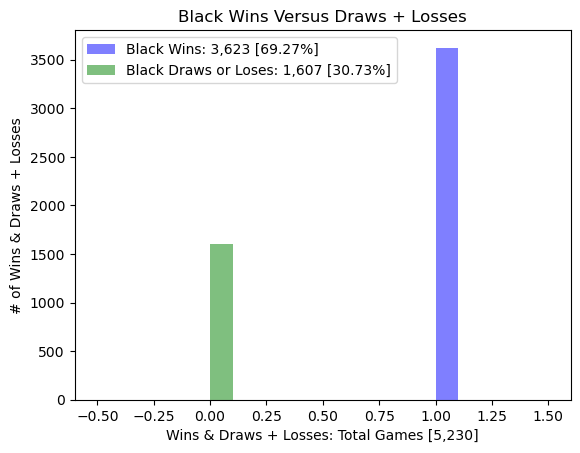

In [955]:
# Look at stronger black players, greater than 100 ELO, and map black wins to 1 and black draws or losses to 0.
# Perform t-test to analyze the p-value and ultimately the null & alternate hypotheses for black differentials.
# Histogram plot displaying black wins versus black draws and losses when black is the superior opponent.

def chess_differentials_black(chess_df):
    chess_df = chess_df.copy()
    chess_df['Rating Differential Black'] = (chess_df['black_rating'] - chess_df['white_rating']).astype(int)
    white_wins = chess_df[(chess_df['Rating Differential Black'] > 100) & (chess_df['winner'] == 'white')].value_counts()
    black_greater_100 = chess_df[(chess_df['Rating Differential Black'] > 100)]

    def victory_status(s):
        if s == 'white' or s == 'draw' :
            return 0

        else:
            return 1
    
    black_greater_100['winner'] = black_greater_100['winner'].apply(victory_status).astype(int)
    
    black_ttest = spicystats.ttest_ind(black_greater_100['Rating Differential Black'], black_greater_100['winner'], equal_var = False)
    
    fig,ax = plt.subplots()
    
    black_victory = black_greater_100[black_greater_100['winner'] == 1]
    black_draw_or_loss = black_greater_100[black_greater_100['winner'] == 0]
    
    ax.hist(black_victory['winner'], color = 'b', alpha = 0.5, label = 'Black Wins: 3,623 [69.27%]')
    ax.hist(black_draw_or_loss['winner'], color = 'g', alpha = 0.5, label = 'Black Draws or Loses: 1,607 [30.73%]')
    ax.set_title('Black Wins Versus Draws + Losses')
    ax.set_ylabel('# of Wins & Draws + Losses')
    ax.set_xlabel('Wins & Draws + Losses: Total Games [5,230]')

    ax.legend();
   
    black_win_percentage = (3623 /(3623+1607))*100
    black_draw_or_loss_percentage = (1607 /(3623+1607))*100

    return black_greater_100
    # , black_ttest, black_victory, black_draw_or_loss, black_win_percentage, black_draw_or_loss_percentage, white_wins

chess_outcomes_black = chess_differentials_black(chess_games)
chess_outcomes_black

# The p-value is less than 0.05, so we reject the null hypothesis and there is significant difference, or impact, 
# between the black rating differentials, with black being the superior opponent, and who wins the game.
# When only considering wins and draws plus losses of a higher-ranked black opponent, black wins 69.27% of the time and draws or loses 30.73% of the time over 5,230 games.

C:\Users\muscl\AppData\Local\Temp\ipykernel_10528\4065744979.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  white_greater_100['winner'] = white_greater_100['winner'].apply(victory_status).astype(int)
C:\Users\muscl\AppData\Local\Temp\ipykernel_10528\3519963764.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  black_greater_100['winner'] = black_greater_100['winner'].apply(victory_status).astype(int)


{'Pearson White Correlation': 0.1668308149961318,
 'Pearson Black Correlation': 0.17783838499201052,
 'Spearman White Correlation': 0.17851593325759896,
 'Spearman Black Correlation': 0.1902427550086633}

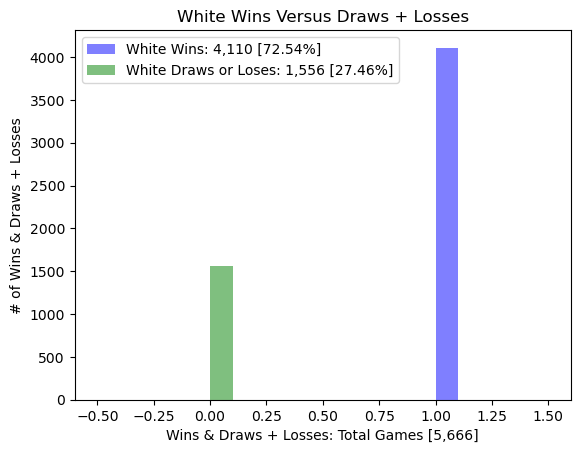

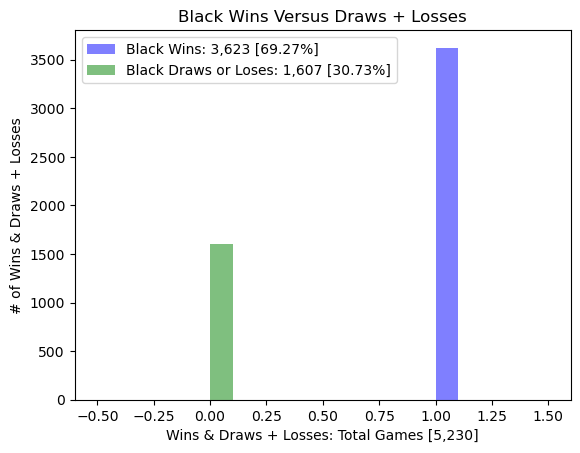

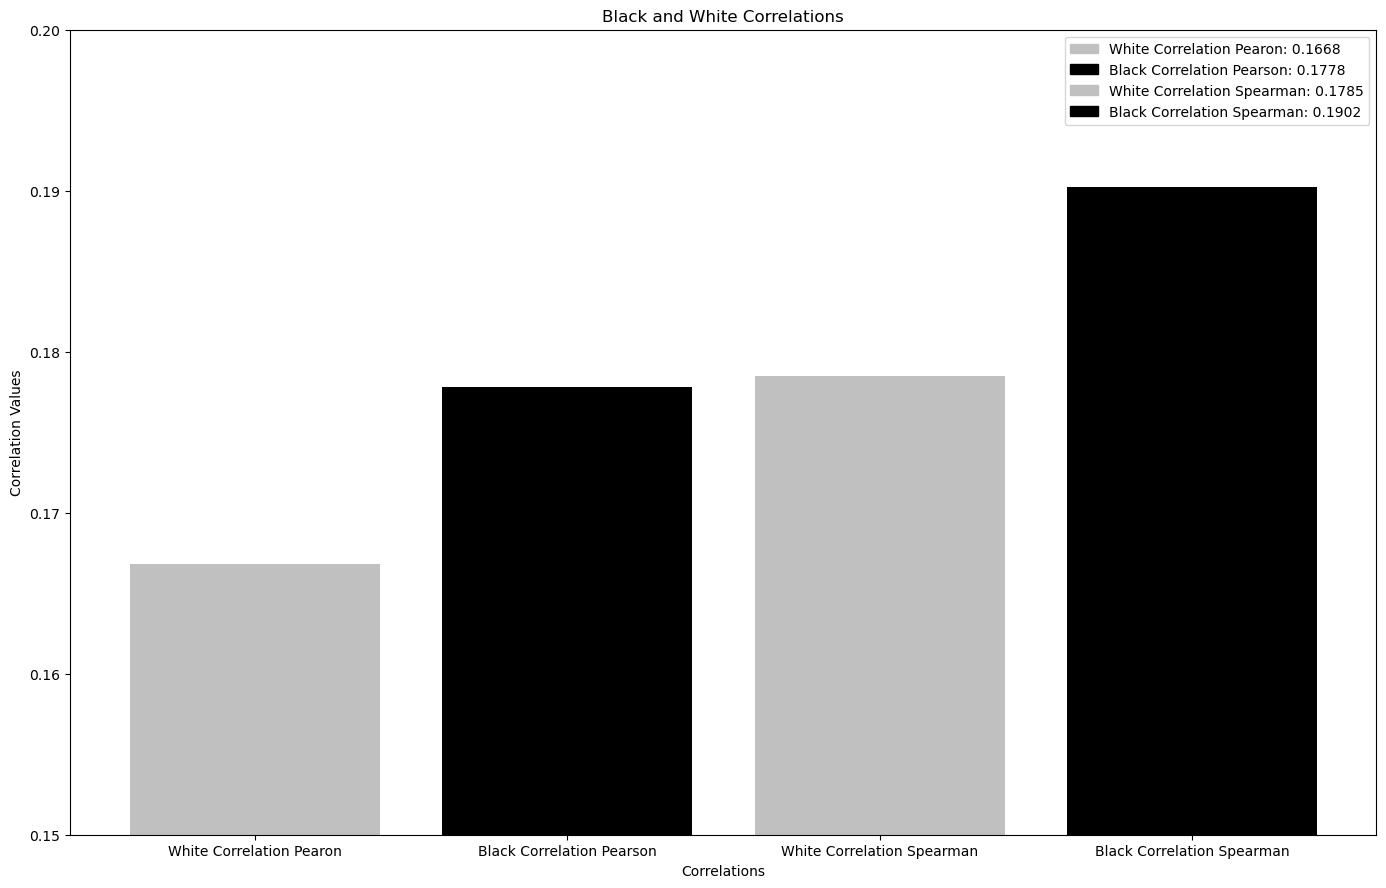

In [1012]:
# Perform nonlinear Spearman correlation to see potential correlations between rating differentals, fow white and black respectively, and their victory status.
def chess_correlations(white, black, path="../images/correlations.png"):
    white = white.copy()
    black = black.copy()
    white_correlation_spearman = white['Rating Differential White'].corr(white['winner'], method ='spearman')

    black_correlation_spearman = black['Rating Differential Black'].corr(black['winner'], method ='spearman')

    white_correlation_pearson = white['Rating Differential White'].corr(white['winner'], method ='pearson')

    black_correlation_pearson = black['Rating Differential Black'].corr(black['winner'], method ='pearson')
    
    fig,ax = plt.subplots()
    x_axis = [white_correlation_pearson, black_correlation_pearson, white_correlation_spearman, black_correlation_spearman]
    x_axis_names = ['White Correlation Pearon', 'Black Correlation Pearson', 'White Correlation Spearman', 'Black Correlation Spearman']
    c = ['silver', 'black', 'silver', 'black']
    
    ax.set_ylim(0.15, 0.20)
    plt.bar(x_axis_names, x_axis, color=c)
    ax.set_title('Black and White Correlations')
    ax.set_ylabel('Correlation Values')
    ax.set_xlabel('Correlations')
    plt.tight_layout()
    fig.set_size_inches(16, 10)
    plt.savefig(path)
    white_pearson_legend = mpatches.Patch(color= 'silver', label='White Correlation Pearon: 0.1668')
    black_pearson_legend = mpatches.Patch(color= 'black', label='Black Correlation Pearson: 0.1778')
    white_spearman_legend = mpatches.Patch(color= 'silver', label='White Correlation Spearman: 0.1785')
    black_spearman_legend = mpatches.Patch(color= 'black', label='Black Correlation Spearman: 0.1902')
    plt.legend(handles=[white_pearson_legend, black_pearson_legend, white_spearman_legend, black_spearman_legend])
   

    return { 'Pearson White Correlation': white_correlation_pearson, 'Pearson Black Correlation': black_correlation_pearson, 'Spearman White Correlation': white_correlation_spearman, 'Spearman Black Correlation': black_correlation_spearman}
all_chess_correlations = chess_correlations(chess_differentials_white(chess_games), chess_differentials_black(chess_games))
all_chess_correlations

# There is no true correlation between white or black being a significantly stronger opponent, in terms of ELO rating, 
# and winning games versus losing or drawing games, as seen from the linear, Pearson correlations and the nonlinear, Spearman correlations below.

C:\Users\muscl\AppData\Local\Temp\ipykernel_10528\2943325409.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  white_greater_100['winner'] = white_greater_100['winner'].apply(


Optimization terminated successfully.
         Current function value: 0.570560
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 winner   No. Observations:                 4532
Model:                          Logit   Df Residuals:                     4529
Method:                           MLE   Df Model:                            2
Date:                Thu, 02 Feb 2023   Pseudo R-squ.:                 0.02948
Time:                        13:05:55   Log-Likelihood:                -2585.8
converged:                       True   LL-Null:                       -2664.3
Covariance Type:            nonrobust   LLR p-value:                 7.765e-35
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
turns                        -0.0037      0.001     -4.453      0.000      -0.

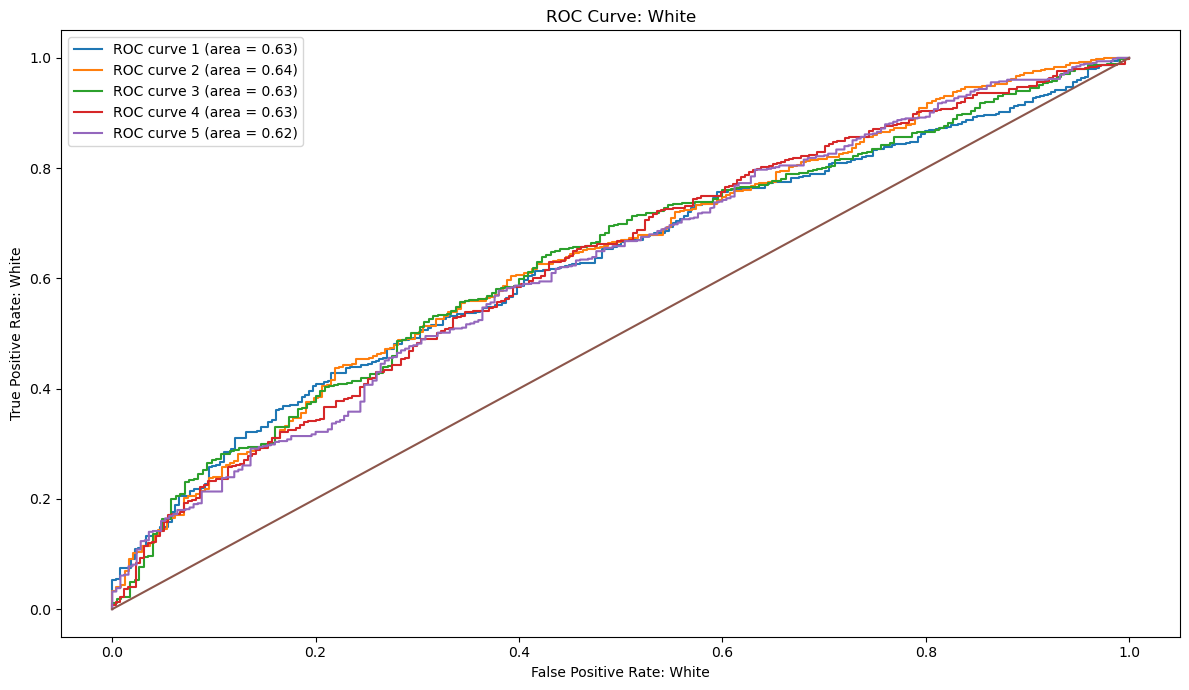

In [1037]:
# Logistic Regression for white with 5 folds, with a data split of 80% for train and 20% for test, to determine true positive rate, or probability of detection, as a fucntion of false positive rate, or probability of false alarm.
# Also, across all 5 folds, the average accuracy, precision, recall, F1 Score, log loss, and log loss probability were determined for white.

def test_train_white(chess_df, path1='../images/roc_curve_white.png', path2='../images/stats_model_white.png'):
    chess_df = chess_df.copy()
    chess_df['Rating Differential White'] = (
        chess_df['white_rating'] - chess_df['black_rating']).astype(int)
    white_greater_100 = chess_df[(chess_df['Rating Differential White'] > 100)]

    def victory_status(s):
        if s == 'black' or s == 'draw':
            return 0

        else:
            return 1

    white_greater_100['winner'] = white_greater_100['winner'].apply(
        victory_status).astype(int)

    X = white_greater_100[['turns', 'opening_ply',
                           'Rating Differential White']].astype(int)
    y = white_greater_100['winner']

    random_seed = 8

    def cross_val_linear(X, y, k):

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=random_seed, stratify=y)

        log_reg = sm.Logit(y_train, X_train).fit()

        print(log_reg.summary())

        plt.rc('figure', figsize=(12, 7))

        plt.text(0.01, 0.05, str(log_reg.summary()), {'fontsize': 10}, fontproperties = 'monospace') 
        plt.title('Logistic Regression Stats Model: White')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(path2)
        plt.clf()

        kf = KFold(k)

        kf.get_n_splits(X_train)

        accuracy_list = []
        precision_list = []
        recall_list = []
        f1_score_list = []
        log_loss_list = []
    
        for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        
            X_train_kfold = X_train.iloc[train_index]
            y_train_kfold = y_train.iloc[train_index]
            X_test_kfold = X_train.iloc[test_index]
            y_test_kfold = y_train.iloc[test_index]

            log_model = LogisticRegression(random_state=random_seed).fit(X_train_kfold, y_train_kfold)
            y_pred = log_model.predict(X_test_kfold)
            y_prob = log_model.predict_proba(X_test_kfold)
            y_hat = log_model.decision_function(X_test_kfold)

            fpr, tpr, thresholds = metrics.roc_curve(y_test_kfold, y_hat)
            roc_auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, label='ROC curve ' + f'{i+1}' + ' (area = %0.2f)' % roc_auc)
        
            accuracy_list.append(metrics.accuracy_score(y_test_kfold, y_pred))
            precision_list.append(metrics.precision_score(y_test_kfold, y_pred))
            recall_list.append(metrics.recall_score(y_test_kfold,y_pred))
            f1_score_list.append(f1_score(y_test_kfold, y_pred, average='binary', zero_division='warn'))
            log_loss_list.append(log_loss(y_test_kfold, y_prob, normalize = True))
            log_loss_prob = (-1*np.log(log_loss_list))
        plt.plot([0,1], [0,1])
        plt.legend()
        plt.title('ROC Curve: White')
        plt.xlabel('False Positive Rate: White')
        plt.ylabel('True Positive Rate: White')
        plt.tight_layout()
        plt.savefig(path1)
        return print({'Mean Accuracy List [White]': np.mean(accuracy_list), 'Mean Precision List [White]': np.mean(precision_list), 'Mean Recall List [White]': np.mean(recall_list), 'Mean F1 Score [White]': np.mean(f1_score_list), 'Mean Log Loss [White]': np.mean(log_loss_list), 'Mean Log Loss Probability [White]': np.mean(log_loss_prob)})
        


    cross_val_linear(X, y, 5)
test_train_white(chess_games)

# The average accuracy and average precision across all 5 folds for white are both respectable and nearly the same with the average accuracy being approximately 72.42% and the average precision being approximately 72.70%.
# Accuracy is a function of true positives, true negatives, false positives, or probability of false alarms, and false negatives, or probability of incorrectly identifying that an attribute is absent.
# We can ascertain that our logistic regression model is being reduced due to the reasonable amount of false positives that are present and is supported by our precision also being reduced due to the same false positive generation.
# Precision is a function of true positives, or probability of detection, and false positives, which is the probability of a false alarm. 
# We can ascertain that our logistic regression model has a reasonable amount of false positives, or incorrectly predicting the positive class of 1, when it should be predicting the negative class of 0, hence false positives are generated. 
# The average recall across all 5 folds for white was excellent with a result of approximately 99.24%.
# Recall is a function of true positives, or probability of detection, and false negatives, which is the probability of incorrectly identifying that an attribute is absent.
# We can ascertain that our logistic regression model has very few false negatives, which would be missing the ability to successsfully predict the correct, positive class of 1 and instead predicting a negative class of 0.
# The average F1 Score across all 5 folds for white was very good with a result of approximately 83.91%.
# The average F1 score is a function of the average precision and average recall. 
# The relatively good mean precision of 72.70% and stellar mean recall of 99.24% is yielding the great F1 score of approximately 83.91% 
# The average log loss across all 5 folds for white was only average with a result of approximately 0.5660, where 0 is optimal. 
# The associated average probability of the log loss across all 5 folds for white was determined to be approximately 0.5696, which effectively denotes the probability of the logistic regression model predicting the proper class, 0 for draws & losses, and 1 for wins, respectively.
# The mediocre result for average log loss and average log loss probability could be due to an imbalanced dataset that truly contains significantly more wins, or binary values of 1, in comparsion to draws & losses, or binary values of 0.

C:\Users\muscl\AppData\Local\Temp\ipykernel_10528\2043139491.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  black_greater_100['winner'] = black_greater_100['winner'].apply(victory_status).astype(int)


Optimization terminated successfully.
         Current function value: 0.598554
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 winner   No. Observations:                 4184
Model:                          Logit   Df Residuals:                     4181
Method:                           MLE   Df Model:                            2
Date:                Thu, 02 Feb 2023   Pseudo R-squ.:                 0.02985
Time:                        13:08:21   Log-Likelihood:                -2504.3
converged:                       True   LL-Null:                       -2581.4
Covariance Type:            nonrobust   LLR p-value:                 3.391e-34
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
turns                        -0.0010      0.001     -1.212      0.225      -0.

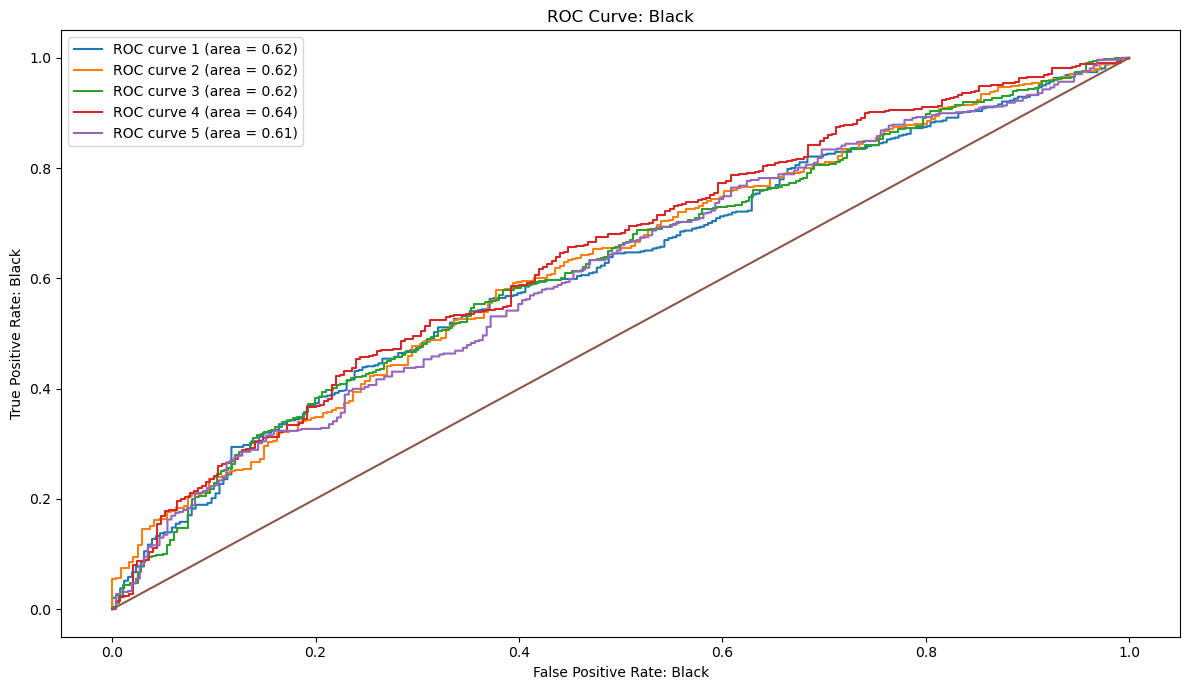

In [1039]:
# Logistic Regression for black with 5 folds, with a data split of 80% for train and 20% for test, to determine true positive rate, or probability of detection, as a fucntion of false positive rate, or probability of false alarm. 
# Also, across all 5 folds, the average accuracy, precision, recall, F1 Score, log loss, and log loss probability were determined for black.

def test_train_black(chess_df, path1='../images/roc_curve_black.png', path2='../images/stats_model_black.png'):
    chess_df = chess_df.copy()
    chess_df['Rating Differential Black'] = (chess_df['black_rating'] - chess_df['white_rating']).astype(int)
    black_greater_100 = chess_df[(chess_df['Rating Differential Black'] > 100)]

    def victory_status(s):
        if s == 'white' or s == 'draw' :
            return 0

        else:
            return 1
    
    black_greater_100['winner'] = black_greater_100['winner'].apply(victory_status).astype(int)


    X = black_greater_100[['turns', 'opening_ply', 'Rating Differential Black']].astype(int)
    y = black_greater_100['winner']

    random_seed = 8
   
    
    def cross_val_linear(X, y, k):    
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)

        log_reg = sm.Logit(y_train, X_train).fit()

        print(log_reg.summary())

        plt.rc('figure', figsize=(12, 7))

        plt.text(0.01, 0.05, str(log_reg.summary()), {'fontsize': 10}, fontproperties = 'monospace') 
        plt.title('Logistic Regression Stats Model: Black')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(path2)
        plt.clf()
    
        kf = KFold(k)
    
        kf.get_n_splits(X_train)

        accuracy_list = []
        precision_list = []
        recall_list = []
        f1_score_list = []
        log_loss_list = []
    
        for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        
            X_train_kfold = X_train.iloc[train_index]
            y_train_kfold = y_train.iloc[train_index]
            X_test_kfold = X_train.iloc[test_index]
            y_test_kfold = y_train.iloc[test_index]

            log_model = LogisticRegression(random_state=random_seed).fit(X_train_kfold, y_train_kfold)
            y_pred = log_model.predict(X_test_kfold)
            y_prob = log_model.predict_proba(X_test_kfold)
            y_hat = log_model.decision_function(X_test_kfold)

            fpr, tpr, thresholds = metrics.roc_curve(y_test_kfold, y_hat)
            roc_auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, label='ROC curve ' + f'{i+1}' + ' (area = %0.2f)' % roc_auc)
        
            accuracy_list.append(metrics.accuracy_score(y_test_kfold, y_pred))
            precision_list.append(metrics.precision_score(y_test_kfold, y_pred))
            recall_list.append(metrics.recall_score(y_test_kfold,y_pred))
            f1_score_list.append(f1_score(y_test_kfold, y_pred, average='binary', zero_division='warn'))
            log_loss_list.append(log_loss(y_test_kfold, y_prob, normalize = True))
            log_loss_prob = (-1*np.log(log_loss_list))
        plt.plot([0,1], [0,1])
        plt.legend()
        plt.title('ROC Curve: Black')
        plt.xlabel('False Positive Rate: Black')
        plt.ylabel('True Positive Rate: Black')
        plt.tight_layout()
        plt.savefig(path1)
        return print({'Mean Accuracy List [Black]': np.mean(accuracy_list), 'Mean Precision List [Black]': np.mean(precision_list), 'Mean Recall List [Black]': np.mean(recall_list), 'Mean F1 Score [Black]': np.mean(f1_score_list), 'Mean Log Loss [Black]': np.mean(log_loss_list), 'Mean Log Loss Probability [Black]': np.mean(log_loss_prob)})
        


    cross_val_linear(X, y, 5)
test_train_black(chess_games)

# The average accuracy and average precision across all 5 folds for black are both respectable and nearly the same with the average accuracy being approximately 69.38% and the average precision being approximately 69.39%.
# Accuracy is a function of true positives, true negatives, false positives, or probability of false alarms, and false negatives, or probability of incorrectly identifying that an attribute is absent.
# We can ascertain that our logistic regression model is being reduced due to the reasonable amount of false positives that are present and is supported by our precision also being reduced due to the same false positive generation.
# Precision is a function of true positives, or probability of detection, and false positives, which is the probability of a false alarm. 
# We can ascertain that our logistic regression model has a reasonable amount of false positives, or incorrectly predicting the positive class of 1, when it should be predicting the negative class of 0, hence false positives are generated. 
# The average recall across all 5 folds for black was excellent with a result of approximately 99.83%.
# Recall is a function of true positives, or probability of detection, and false negatives, which is the probability of incorrectly identifying that an attribute is absent.
# We can ascertain that our logistic regression model has very few false negatives, which would be missing the ability to successsfully predict the correct, positive class of 1 and instead predicting a negative class of 0.
# The average F1 Score across all 5 folds for black was very good with a result of approximately 81.86%.
# The average F1 score is a function of the average precision and average recall. 
# The relatively good mean precision of 69.39% and stellar mean recall of 99.83% is yielding the great F1 score of approximately 81.86% 
# The average log loss across all 5 folds for black was only average with a result of approximately 0.5969, where 0 is optimal. 
# The associated average probability of the log loss across all 5 folds for black was determined to be approximately 0.5162, which effectively denotes the probability of the logistic regression model predicting the proper class, 0 for draws & losses, and 1 for wins, respectively.
# The mediocre result for average log loss and average log loss probability could be due to an imbalanced dataset that truly contains significantly more wins, or binary values of 1, in comparsion to draws & losses, or binary values of 0.

In [ ]:
# Conclusion
# When comparing filtered games where white is the superior opponent with black being the superior opponent, the total games in each respective database very similar with comparable wins versus draws and losses. 
# When running one version of a logistic regression model for both white and black games, we see very similar average metrics for the accuracy, precision, recall, F1 score, log loss, and log loss probability. 
# However, when utilizing a different logistic regression statistical model, a worthwhile not is looking at the respective inputs, or features, for our white and black chess games, respectively. 
# The three features utilized for both black and white games were rating differential, number of turns in the game, and opening play, which is the consecutive moves from the initiation of the game that opponents stick to an optimal, book opening. 
# In general, typically skilled players, even with reasonable rating differentials, will have games with a substantial amount of moves because they avoid suboptimal moves and outright blunders.
# More specifically, with the white games, our three features all had p-values of 0.000, which are significant since they are less than 0.05, and thus are a good choice to be incorporated into predicting our target, or binary output of wins versus draws and losses.
# Regarding the black games, the rating differential feature was determined to be significant at 0.000, but interestingly enough the number of terms and opening play were didn't yeild significant p-values, or greater than 0.05, at 0.225 and 0.372, respectively.
# There has been extensive, cumulative analysis on chess throughout the years to determine that white has an innate advantage simply by being the first player to make a move.
# The respective difference in significances of our features between white and black games might indicate the fact that due to the inherent disadvantage of black being the responsive player, there is no significance on the number of moves and sticking to an optimal book opening. 
# Essentially, the disadvantage of moving second might trump the ability to follow optimal book openings and play in technically sound games that contain a large number of moves.